In [1]:
! pip install pyquaternion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import cv2
# import quaternion
from pyquaternion import Quaternion
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch
from torchvision.transforms import ToTensor

In [143]:
depth0 = cv2.imread("./test.depth.00000.png",cv2.IMREAD_ANYDEPTH)
depth1 = cv2.imread("./test.depth.00001.png",cv2.IMREAD_ANYDEPTH)
depth0 = depth0/255*10
depth1 = depth1/255*10
# cv2 read bgr image
print(np.max(depth0))
frame0 = cv2.imread("./test.rgba.00000.png",cv2.IMREAD_COLOR)
frame1 = cv2.imread("./test.rgba.00001.png",cv2.IMREAD_COLOR)
frame0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

2.235294117647059


In [144]:
position0 = [-0.6, -0.4084224, -0.25]
position1 = [-0.6, -0.4084224, -0.25]
quat0 = [1, 0, 0, 0]
quat1 = [0.965925872325897, 0, -0.258819073438644, 0]

In [145]:
hfov = float(90) * np.pi / 180.
# hfov =90
K = np.array([
    [1 / np.tan(hfov / 2.), 0., 0., 0.],
    [0., 1 / np.tan(hfov / 2.), 0., 0.],
    [0., 0.,  1, 0],
    [0., 0., 0, 1]])

In [147]:
H,W = depth0.shape

# Now get an approximation for the true world coordinates -- see if they make sense
# [-1, 1] for x and [1, -1] for y as array indexing is y-down while world is y-up
xs, ys = np.meshgrid(np.linspace(-1,1,W), np.linspace(1,-1,H))
# xs, ys = np.meshgrid(np.linspace(0,W-1,W), np.linspace(0,H-1,H))

depth = depth0.reshape(1,H,W)
xs = xs.reshape(1,H,W)
ys = ys.reshape(1,H,W)

In [148]:
# Unproject
# negate depth as the camera looks along -Z
xys = np.vstack((xs * depth , ys * depth, -depth, np.ones(depth.shape)))
xys = xys.reshape(4, -1)
xy_c0 = np.matmul(np.linalg.inv(K), xys)

In [149]:
# Now load in the cameras, are in the format camera --> world
quaternion_0 = np.array(quat0).astype(float)
quaternion_0 = Quaternion(quaternion_0)
translation_0 = np.array(position0)
rotation_0 = quaternion_0.rotation_matrix  
T_world_camera0 = np.eye(4)
T_world_camera0[0:3,0:3] = rotation_0
T_world_camera0[0:3,3] = translation_0

quaternion_1 = np.array(quat1).astype(float)
quaternion_1 = Quaternion(quaternion_1)
translation_1 = np.array(position1)
rotation_1 = quaternion_1.rotation_matrix  
T_world_camera1 = np.eye(4)
T_world_camera1[0:3,0:3] =  rotation_1
T_world_camera1[0:3,3] = translation_1

In [150]:
# Invert to get world --> camera
T_camera1_world = np.linalg.inv(T_world_camera1)

# Transformation matrix between views
# Aka the position of camera0 in camera1's coordinate frame
T_camera1_camera0 = np.matmul(T_camera1_world, T_world_camera0)

In [151]:
# Finally transform actual points
xy_c1 = np.matmul(T_camera1_camera0, xy_c0)
xy_newimg = np.matmul(K, xy_c1)

# Normalize by negative depth
xys_newimg = xy_newimg[0:2,:] / -xy_newimg[2:3,:]
# Flip back to y-down to match array indexing
xys_newimg[1] *= -1

print(xys_newimg)

[[-3.73205127 -3.72040437 -3.70880701 ...  0.26627125  0.26711068
   0.26794916]
 [-2.73205112 -2.72622767 -2.72042899 ...  0.73288976  0.73247004
   0.7320508 ]]


In [152]:
# Create sampler
sampler = torch.Tensor(xys_newimg).view(2, H, W).permute(1,2,0).unsqueeze(0)

In [153]:
# Create generated image
img1_tensor = ToTensor()(frame0).unsqueeze(0)
img2_tensor = ToTensor()(frame1).unsqueeze(0)
img2_warped = F.grid_sample(img2_tensor, sampler)

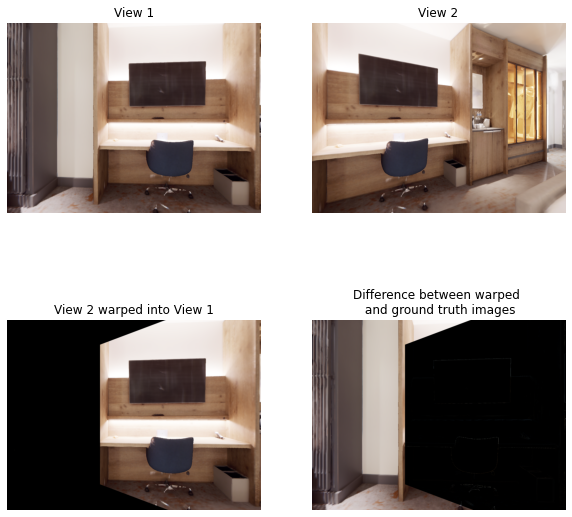

In [155]:
# Visualise
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax1.imshow(img1_tensor.squeeze().permute(1,2,0))
ax1.set_title("View 1", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(222)
ax1.imshow(img2_tensor.squeeze().permute(1,2,0))
ax1.set_title("View 2", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(223)
plt.imshow(img2_warped.squeeze().permute(1,2,0))
ax1.set_title("View 2 warped into View 1", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(224)
ax1.imshow(np.abs(img2_warped.squeeze().permute(1,2,0) - img1_tensor.squeeze().permute(1,2,0)))
ax1.set_title("Difference between warped \n and ground truth images", fontsize='large')
ax1.axis('off')
plt.show()

# **The original one without modifying**

In [135]:
depth0 = cv2.imread("./test.depth.00001.png",cv2.IMREAD_ANYDEPTH)
depth1 = cv2.imread("./test.depth.00002.png",cv2.IMREAD_ANYDEPTH)
depth0 = depth0 / 255 * 10
depth1 = depth1 / 255 * 10
# cv2 read bgr image
frame0 = cv2.imread("./test.rgba.00001.png",cv2.IMREAD_COLOR)
frame1 = cv2.imread("./test.rgba.00002.png",cv2.IMREAD_COLOR)
frame0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

H,W = depth0.shape
print(np.max(depth0))

4.705882352941177


In [136]:
position0 = [-0.6, -0.4084224, -0.25]
position1 = [-0.47500002, -0.4256638,  -0.46650636]
quat0 = [0.965925872325897, 0, -0.258819073438644, 0]
quat1 = [0.965925872325897, 0, -0.258819073438644, 0]

# small settings
# position0 = [-0.6,       -0.4084224, -0.05     ]
# position1 = [-0.57500005, -0.4118707,  -0.09330127]
# quat0 = [0.965925872325897, 0, -0.258819073438644, 0]
# quat1 = [0.965925872325897, 0, -0.258819073438644, 0]

hfov = float(90) * np.pi / 180.
# hfov =90
K = np.array([
    [1 / np.tan(hfov / 2.), 0., 0., 0.],
    [0., 1 / np.tan(hfov / 2.), 0., 0.],
    [0., 0.,  1, 0],
    [0., 0., 0, 1]])

In [137]:
H,W = depth0.shape

# Now get an approximation for the true world coordinates -- see if they make sense
# [-1, 1] for x and [1, -1] for y as array indexing is y-down while world is y-up
xs, ys = np.meshgrid(np.linspace(-1,1,W), np.linspace(1,-1,H))
# xs = np.ones((W,W))
# ys = np.ones((W,W))
print(xs.shape)

depth = depth0.reshape(1,H,W)
xs = xs.reshape(1,H,W)
ys = ys.reshape(1,H,W)

(960, 1280)


In [138]:
# Unproject
# negate depth as the camera looks along -Z
xys = np.vstack((xs * depth , ys * depth, -depth, np.ones(depth.shape)))
xys = xys.reshape(4, -1)
xy_c0 = np.matmul(np.linalg.inv(K), xys)


In [139]:
# Now load in the cameras, are in the format camera --> world
quaternion_0 = np.array(quat0).astype(float)
quaternion_0 = Quaternion(quaternion_0)
translation_0 = np.array(position0)
rotation_0 = quaternion_0.rotation_matrix  
T_world_camera0 = np.eye(4)
T_world_camera0[0:3,0:3] = rotation_0
T_world_camera0[0:3,3] = translation_0

quaternion_1 = np.array(quat1).astype(float)
quaternion_1 = Quaternion(quaternion_1)
translation_1 = np.array(position1)
rotation_1 = quaternion_1.rotation_matrix  
T_world_camera1 = np.eye(4)
T_world_camera1[0:3,0:3] =  rotation_1
T_world_camera1[0:3,3] = translation_1

In [140]:
# Invert to get world --> camera
T_camera1_world = np.linalg.inv(T_world_camera1)

# Transformation matrix between views
# Aka the position of camera0 in camera1's coordinate frame
T_camera1_camera0 = np.matmul(T_camera1_world, T_world_camera0)

# Finally transform actual points
xy_c1 = np.matmul(T_camera1_camera0, xy_c0)
xy_newimg = np.matmul(K, xy_c1)

# Normalize by negative depth
xys_newimg = xy_newimg[0:2,:] / -xy_newimg[2:3,:]
# Flip back to y-down to match array indexing
xys_newimg[1] *= -1

print(xys_newimg)


[[-1.24878046 -1.24682771 -1.24487497 ...  1.54354466  1.54596591
   1.54838715]
 [-1.26593778 -1.26593778 -1.26593778 ...  1.51056724  1.51056724
   1.51056724]]


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


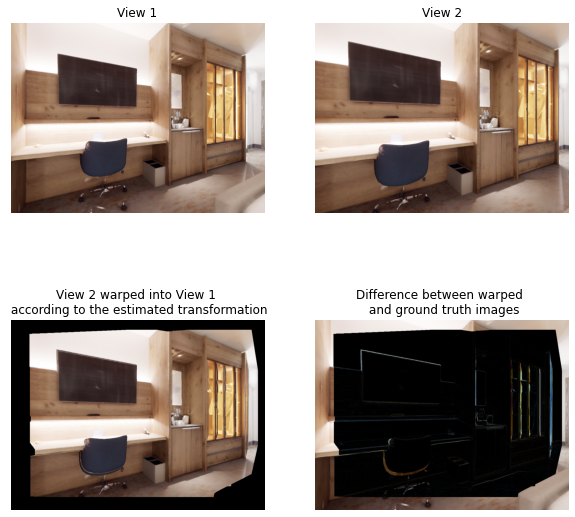

In [141]:

# Create sampler
sampler = torch.Tensor(xys_newimg).view(2, H, W).permute(1,2,0).unsqueeze(0)

# Create generated image
img1_tensor = ToTensor()(frame0).unsqueeze(0)
img2_tensor = ToTensor()(frame1).unsqueeze(0)
img2_warped = F.grid_sample(img2_tensor, sampler)

# Visualise
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax1.imshow(img1_tensor.squeeze().permute(1,2,0))
ax1.set_title("View 1", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(222)
ax1.imshow(img2_tensor.squeeze().permute(1,2,0))
ax1.set_title("View 2", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(223)
plt.imshow(img2_warped.squeeze().permute(1,2,0))
ax1.set_title("View 2 warped into View 1", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(224)
ax1.imshow(np.abs(img2_warped.squeeze().permute(1,2,0) - img1_tensor.squeeze().permute(1,2,0)))
ax1.set_title("Difference between warped \n and ground truth images", fontsize='large')
ax1.axis('off')
plt.show()